In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Input datasets

## Flensburg district heating demand

Includes three years of operation with feed flow and return flow temperatures.

- Source: Stadtwerke Flensburg GmbH (2019). District heating network data for the city of Flensburg from 2014-2016 [Data set]. Zenodo. doi: [10.5281/zenodo.2562658](https://doi.org/10.5281/zenodo.2562658)

In [2]:
df = pd.read_csv("./district-heating-network-data-flensburg-2014-2016.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d/%m/%y %H:%M")
# select 2014 as sample year
df = df.loc[df["Datetime"].dt.year == 2014].copy()

## DEKADE

Normed profile from 82 profiles from all over Germany, which does include
ambient temperature (all values by arithmetic mean). 

- Source: Merlin Sebastian Triebs, Elisa Papadis, Hannes Cramer, George Tsatsaronis (2021). Landscape of district heating systems in Germany – Status quo and categorization. Energy Conversion and Management: X, 9, 100068, doi: [10.1016/j.ecmx.2020.100068](https://doi.org/10.1016/j.ecmx.2020.100068).


In [3]:
df_norm = pd.read_csv("dekade.csv")
df_norm["Temp"] -= 273.15
df_norm["Temp"] = df_norm["Temp"].round(1)
df_norm["T_feed"] = np.nan
df_norm["dt"] = pd.to_datetime(df_norm["dt"])

## Compare normalized data with Flensburg data

Structure matches very well, we will use DEKADE moving forward

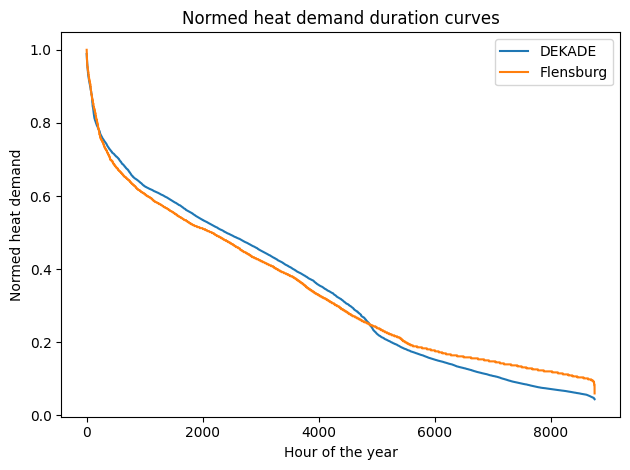

In [4]:
fig, ax = plt.subplots()

ax.set_title("Normed heat demand duration curves")

ax.plot(range(8760), df_norm["Q/Q_max"].sort_values(ascending=False), label="DEKADE")
ax.plot(range(8760), (df["Overall heat load in MW"] / df["Overall heat load in MW"].max()).sort_values(ascending=False), label="Flensburg")

ax.set_xlabel("Hour of the year")
ax.set_ylabel("Normed heat demand")
ax.legend()

plt.tight_layout()


## Calculate feed-flow temperatures with Heizkurve

Depending on ambient temperature map the feed-flow temperature

- 80 °C for T ambient below -5 °C
- 60 °C for T ambient above 15 °C
- linear interpolation in between

In [5]:
T_feed_max = 80
T_feed_min = 60

T_amb_max = 15
T_amb_min = -5

T_feed_max_mask = df_norm["Temp"] <= T_amb_min
T_feed_min_mask = df_norm["Temp"] >= T_amb_max
T_feed_linear = ~(T_feed_max_mask | T_feed_min_mask)


In [6]:
df_norm.loc[T_feed_max_mask, "T_feed"] = T_feed_max
df_norm.loc[T_feed_min_mask, "T_feed"] = T_feed_min
df_norm.loc[T_feed_linear, "T_feed"] = T_feed_min + (T_feed_max - T_feed_min) * (
    (T_amb_max - df_norm.loc[T_feed_linear, "Temp"]) / (T_amb_max - T_amb_min)
)

Check if linear interpolation produced the desired results

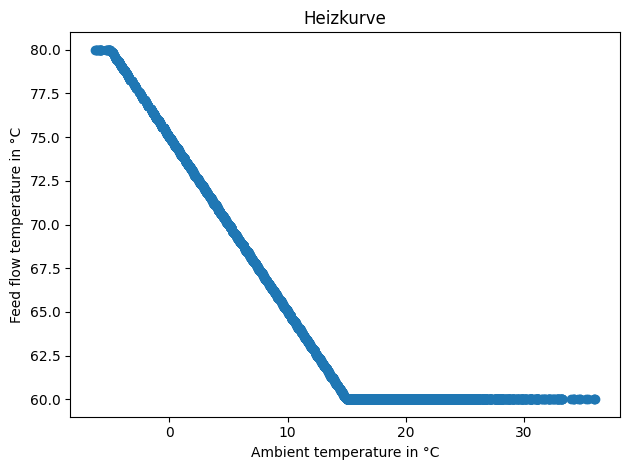

In [7]:
fig, ax = plt.subplots(1)

ax.scatter(df_norm["Temp"], df_norm["T_feed"])
ax.set_ylabel("Feed flow temperature in °C")
ax.set_xlabel("Ambient temperature in °C")

ax.set_title("Heizkurve")

plt.tight_layout()

## Scaling heat demand data to make heat pump fit into it

In [8]:
df_norm["Q"] = df_norm["Q/Q_max"] * 3000

## Aggregating to daily values

In [9]:
df_daily_summer = df_norm.groupby(by=df_norm["dt"].dt.dayofyear).agg(
    {
        "dt": "first",
        "T_feed": "mean",
        "Q": "mean"
    }
)

## Operation pattern: spring to fall

In [10]:
heat_nomnial_heat_pump = 700
heat_minimum_heat_pump = heat_nomnial_heat_pump * 0.4

offset = 0

heat_nomnial_heat_pump += offset
heat_minimum_heat_pump += offset

df_daily_summer["heat_pump"] = df_daily_summer["Q"]

mask_max = df_daily_summer["Q"] > heat_nomnial_heat_pump
df_daily_summer.loc[mask_max, "heat_pump"] = heat_nomnial_heat_pump

mask_min = df_daily_summer["Q"] < heat_minimum_heat_pump
df_daily_summer.loc[mask_min, "heat_pump"] = 0

mask_winter = (df_daily_summer["dt"].dt.dayofyear < 31+ 28 + 20) | (df_daily_summer["dt"].dt.dayofyear > 365 - 11)
df_daily_summer.loc[mask_winter, "heat_pump"] = 0
df_daily_summer.index -= 1

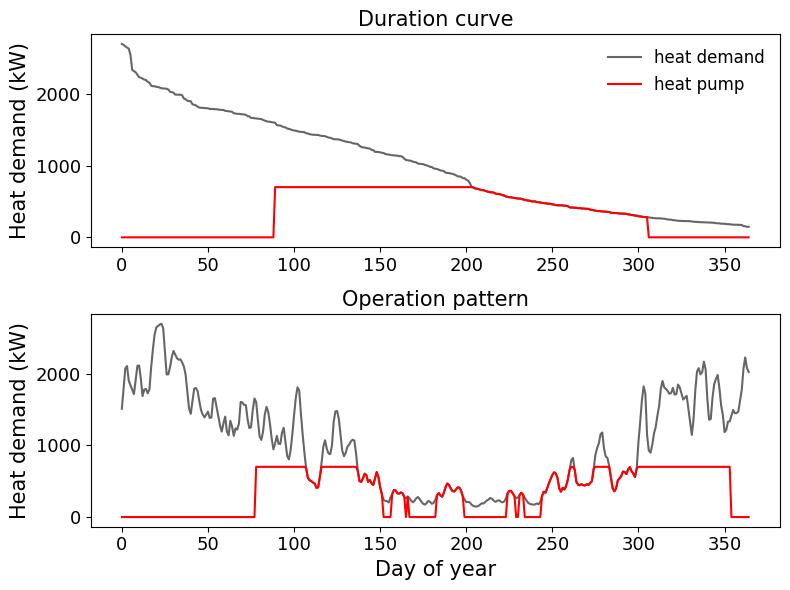

In [11]:
fig, ax = plt.subplots(2, figsize=(8, 6))

ax[0].plot(df_daily_summer.index, df_daily_summer["Q"].sort_values(ascending=False), color="#666666", label="heat demand")
ax[0].plot(df_daily_summer.index, df_daily_summer["heat_pump"].sort_values(ascending=False).shift(89, fill_value=0), color="red", label="heat pump")

ax[1].plot(df_daily_summer.index, df_daily_summer["Q"], label="heat demand", color="#666666")
ax[1].plot(df_daily_summer.index, df_daily_summer["heat_pump"], label="heat pump", color="red")

ax[0].set_title("Duration curve", fontsize=15)
ax[0].set_ylabel("Heat demand (kW)", fontsize=15)
ax[0].tick_params(axis="x", labelsize=13)
ax[0].tick_params(axis="y", labelsize=13)

ax[1].set_title("Operation pattern", fontsize=15)
ax[1].set_xlabel("Day of year", fontsize=15)
ax[1].set_ylabel("Heat demand (kW)", fontsize=15)
ax[1].tick_params(axis="x", labelsize=13)
ax[1].tick_params(axis="y", labelsize=13)
ax[0].legend(frameon=False, loc="upper right", prop={'size': 12})

plt.tight_layout()

fig.savefig("operation_heat_pump_summer.pdf")

## Operation pattern: fall to spring

In [12]:
offset = 800

heat_nomnial_heat_pump += offset
heat_minimum_heat_pump += offset

df_daily_winter = df_daily_summer.copy()

df_daily_winter["heat_pump"] = df_daily_winter["Q"]

mask_max = df_daily_winter["Q"] > heat_nomnial_heat_pump
df_daily_winter.loc[mask_max, "heat_pump"] = heat_nomnial_heat_pump

mask_min = df_daily_winter["Q"] < heat_minimum_heat_pump
df_daily_winter.loc[mask_min, "heat_pump"] = 0

mask_on = df_daily_winter["heat_pump"] > 0
df_daily_winter.loc[mask_on, "heat_pump"] -= offset


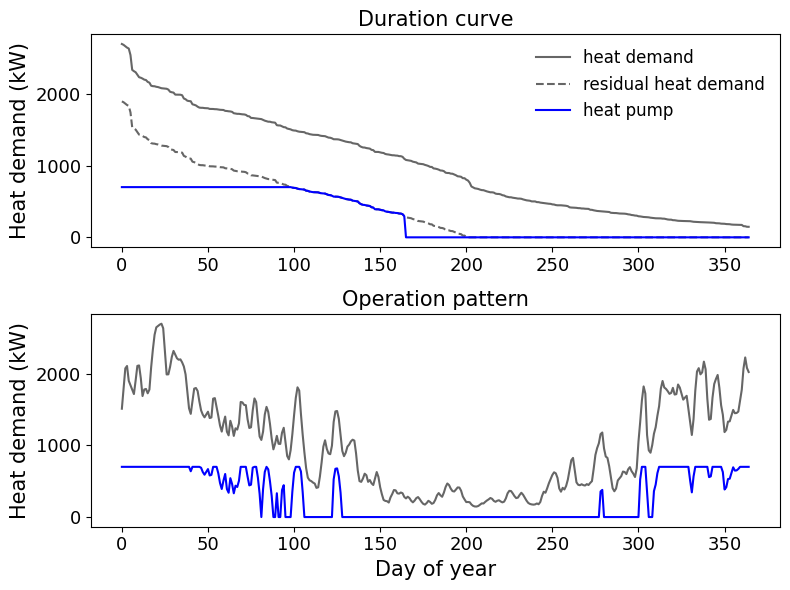

In [13]:
fig, ax = plt.subplots(2, figsize=(8, 6))

_df_daily_winter = df_daily_winter.copy()
_df_daily_winter["residual demand"] = _df_daily_winter["Q"] - offset
_df_daily_winter.loc[_df_daily_winter["residual demand"] < 0, "residual demand"] = 0

ax[0].plot(df_daily_winter.index, (_df_daily_winter["Q"]).sort_values(ascending=False), color="#666666", label="heat demand")
ax[0].plot(df_daily_winter.index, _df_daily_winter["residual demand"].sort_values(ascending=False), color="#666666", linestyle="--", label="residual heat demand")
ax[0].plot(df_daily_winter.index, df_daily_winter["heat_pump"].sort_values(ascending=False), color="blue", label="heat pump")

ax[1].plot(df_daily_winter.index, _df_daily_winter["Q"], label="heat demand", color="#666666")
ax[1].plot(df_daily_winter.index, df_daily_winter["heat_pump"], label="heat pump", color="blue")

ax[0].set_title("Duration curve", fontsize=15)
ax[0].set_ylabel("Heat demand (kW)", fontsize=15)
ax[0].tick_params(axis="x", labelsize=13)
ax[0].tick_params(axis="y", labelsize=13)

ax[1].set_title("Operation pattern", fontsize=15)
ax[1].set_xlabel("Day of year", fontsize=15)
ax[1].set_ylabel("Heat demand (kW)", fontsize=15)
ax[1].tick_params(axis="x", labelsize=13)
ax[1].tick_params(axis="y", labelsize=13)
ax[0].legend(frameon=False, loc="upper right", prop={'size': 12})

plt.tight_layout()

fig.savefig("operation_heat_pump_winter.pdf")

In [14]:
index = np.arange(0, 24, 1)
index = np.concatenate([index, np.arange(index[-1] + 1, 24 * 6 + 1, 4)])
index = np.concatenate([index, np.arange(index[-1] + 24, 24 * 365, 24)])

In [15]:
df = pd.DataFrame()
df["Time"] = index
df["day"] = index // 24
df["T_feed"] = df["day"].map(df_daily_summer["T_feed"].to_dict())
df["heat_pump"] = df["day"].map(df_daily_summer["heat_pump"].to_dict())

df_daily_summer.to_csv("schedule_daily_summer.csv")
df.to_csv("schedule_coupling_summer.csv")

In [16]:
df = pd.DataFrame()
df["Time"] = index
df["day"] = index // 24
df["T_feed"] = df["day"].map(df_daily_winter["T_feed"].to_dict())
df["heat_pump"] = df["day"].map(df_daily_winter["heat_pump"].to_dict())

df_daily_winter.to_csv("schedule_daily_winter.csv")
df.to_csv("schedule_coupling_winter.csv")